# Table Of Content
- [installation of dependencies](#install_deps)  
- [installation of main package](#install_main)  
- [starting the notebook](#start)  
- [download test data](#download)  
- [DEM preparation](#demprep)  
  * [GAMMA](#demprep_gamma)  
  * [SNAP](#demprep_snap)
- [DEM comparison](#dem_compare)  
  * [Computate Slope and Aspect](#slope_aspect)  
  * [Analysis of DEM Slope-Aspect Distribution](#dem_distribution) 
  * [DEM absolute difference maps](#dem_diff)
- [Processing](#proc) 
  * [GAMMA](#proc_gamma)  
  * [SNAP](#proc_snap)  
- [LULC Masks](#lulc)  
  * [Alps: CORINE](#corine)  
  * [Fiji: Shapefile Rasterization](#rasterize)  
- [Comparison of backscatter with local angle of incidence](#sar_inc)   
- [Comparison of SNAP terrain flattening results](#snap_tf)  
- [Comparison of SNAP vs. GAMMA stratified by terrain](#snap_gamma_terrain)  
- [Comparison of local incident angle maps](#inc_comp)  
- [Todo](#todo) 

# prerequisites
In some of the following cells directories and files are going to be created. The currect structure is organized such that a main directory exists in which the sub-directories and files are stored.  
Files specific to a Sentinel-1 scene will contain a unique prefix in their name, which consists of the sensor identifier, the acquisition mode, the orbit and the acquisition start time.  
The code directory can be used to clone the GitHub repository ( see later step).  
The following describes an exemplary structure with directories in bold letters.  
* **S1_ARD**
  * **data**
    * **CORINE**
      * e.g. ```clc2018_clc2018_V2018.20b2.tif```
    * **DEM**
      * e.g. ```S1A__IW___A_20180829T170656_dem_gamma_AW3D30```
    * **GAMMA**
      * **e.g. ```S1A__IW___A_20180829T170656_AW3D30```**
        * e.g. ```S1A__IW___A_20180829T170656_VV_grd_mli_norm_geo_db.tif```
    * **SNAP**
      * **e.g. ```S1A__IW___A_20180829T170656_AW3D30```**
        * e.g. ```S1A__IW___A_20180829T170656_VV_bnr_Orb_Cal_TF_TC_dB.tif```
    * **S1**
      * e.g. ```S1A_IW_GRDH_1SDV_20180829T170656_20180829T170721_023464_028DE0_F7BD.zip```
  * **code**
    * **.git**
    * **S1_ARD**
    * data_prepare.ipynb
    * ..

<a id='install_deps'></a>
# install the current spatialist and pyroSAR development branches

```shell
# install git for package versioning
sudo apt-get install git

# uninstall in case the packages have been installed before
python -m pip uninstall spatialist pyroSAR

# install the latest package development versions
python -m pip install git+https://github.com/johntruckenbrodt/spatialist.git@master
python -m pip install git+https://github.com/johntruckenbrodt/pyroSAR.git@master
```

<a id='install_main'></a>
# install/update the S1_ARD package

```shell
# change to the code sub-directory
cd code

# (first start only) clone the GitHub repository
git clone https://github.com/johntruckenbrodt/S1_ARD.git

# change into the cloned directory
cd S1_ARD

# update the project if it has been cloned before
git pull

# install additional dependencies
python -m pip install -r requirements.txt

# add the code location to the PATH environment
export PATH=$PATH:$(pwd)

# change back to main dir
cd ../..
```
## Note
For convenience the code location is best permanently added to the PATH environment by adding a line to the .bashrc file:
```shell
export PATH=$PATH:/path/to/S1_ARD/code
```

<a id='start'></a>
# starting the notebook

```shell
# first start jupyter and then select the notebook from the browser menu
jupyter notebook
```

<a id='download'></a>
# download test data

```shell
# change to the data directory
cd data/S1

#  Alps
wget -c -T120 --no-check-certificate --user="username" --password="password" \
-O S1A_IW_GRDH_1SDV_20180829T170656_20180829T170721_023464_028DE0_F7BD.zip \
"https://scihub.copernicus.eu/dhus/odata/v1/Products('1d498b6b-f890-4c3f-a30e-877338e9f2fe')/\$value"

# Fiji
wget -c -T120 --no-check-certificate --user="username" --password="password" \
-O S1A_IW_GRDH_1SDV_20181229T064000_20181229T064036_025236_02CA47_4B57.zip \
"https://scihub.copernicus.eu/dhus/odata/v1/Products('e4cb3279-5b37-4b5c-8b10-27976e3a6a6f')/\$value"
```

# define the working directory and identify the SAR scene

documentation:
- [pyroSAR.drivers.identify](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.drivers.identify)

In [1]:
import os
from pyroSAR import identify

maindir = '/home/truc_jh/Desktop/S1_ARD/data'
snap5_gpt = '/home/truc_jh/esa-snap5/bin/gpt'

site = 'Alps'
filename = os.path.join(maindir, 'S1', 'S1A_IW_GRDH_1SDV_20180829T170656_20180829T170721_023464_028DE0_F7BD.zip')
epsg = 32632

# site = 'Fiji'
# filename = os.path.join(maindir, 'S1', 'S1A_IW_GRDH_1SDV_20181229T064000_20181229T064036_025236_02CA47_4B57.zip')
# epsg = 32760

id = identify(filename)

print(id)
print('incidence: {:.2f}'.format(id.meta['incidence']))

pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 148
frameNumber: 167392
lines: 16703
orbit: A
orbitNumber_abs: 23464
orbitNumber_rel: 117
polarizations: ['VV', 'VH']
product: GRD
projection: +proj=longlat +datum=WGS84 +no_defs 
samples: 26056
sensor: S1A
spacing: (10.0, 10.0)
start: 20180829T170656
stop: 20180829T170721
incidence: 39.06


<a id='demprep'></a>
# DEM preparation

<a id='demprep_gamma'></a>
## DEM preparation: GAMMA

documentation:
- [pyroSAR.gamma.dem.dem_autocreate](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.gamma.dem.dem_autocreate)
- the download of TanDEM-X 90m DEMs requires a registration, see [here](https://geoservice.dlr.de/web/dataguide/tdm90) for details; once registered the credentials can be passed to function dem_autocreate; for the other DEM options they are ignored
- Conversion from EGM96 geoid to WGS84 ellipsoid heights is performed for all DEMs except for TDX90m, which already contains ellipsoid heights

In [2]:
from pyroSAR.gamma.dem import dem_autocreate

dem_dir = os.path.join(maindir, 'DEM')
if not os.path.isdir(dem_dir):
    os.makedirs(dem_dir)

demfiles_gamma = {}
for demType in ['AW3D30', 'SRTM 1Sec HGT', 'SRTM 3Sec', 'TDX90m']:
    dem_id = demType.replace(' ', '-')
    dem_base = '{}_dem_gamma_{}'.format(id.outname_base(), dem_id)
    dem = os.path.join(dem_dir, dem_base)
    print(dem.replace(maindir, '.'))
    with id.bbox() as bbox:
        dem_autocreate(geometry=bbox, 
                       demType=demType, 
                       outfile=dem, 
                       buffer=0.1,
                       t_srs=epsg, tr=(90, 90),
                       username='username', 
                       password='password',
                       geoid_mode='gdal')
    demfiles_gamma[dem_id] = dem
    print('-' * 10)

./DEM/S1A__IW___A_20180829T170656_dem_gamma_AW3D30
outfile already exists
----------
./DEM/S1A__IW___A_20180829T170656_dem_gamma_SRTM-1Sec-HGT
outfile already exists
----------
./DEM/S1A__IW___A_20180829T170656_dem_gamma_SRTM-3Sec
outfile already exists
----------
./DEM/S1A__IW___A_20180829T170656_dem_gamma_TDX90m
outfile already exists
----------


<a id='demprep_snap'></a>
## DEM preparation: SNAP

documentation:
- [pyroSAR.auxdata.dem_autoload](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.auxdata.dem_autoload)
- [pyroSAR.auxdata.dem_create](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.auxdata.dem_create)

In [3]:
from pyroSAR.auxdata import dem_autoload, dem_create

dem_dir = os.path.join(maindir, 'DEM')
if not os.path.isdir(dem_dir):
    os.makedirs(dem_dir)

demfiles_snap = {}
for demType in ['AW3D30', 'SRTM 1Sec HGT', 'SRTM 3Sec', 'TDX90m']:
    dem_id = demType.replace(' ', '-')
    dem_base = '{}_dem_snap_{}'.format(id.outname_base(), dem_id)
    dem = os.path.join(dem_dir, dem_base + '.tif')
    print(dem.replace(maindir, '.'))
    if not os.path.isfile(dem):
        with id.bbox() as bbox:
            # download all necessary DEM tiles and connect them in an in-memory VRT file
            print('collecting DEM tiles')
            vrt = dem_autoload(geometries=[bbox], 
                               demType=demType,
                               vrt='/vsimem/{}.vrt'.format(dem_base), 
                               buffer=0.1,
                               username='username', 
                               password='password')
            # create a DEM GTiff file from the VRT
            geoid_convert = False if dem_id == 'TDX90m' else True
            dem_create(vrt, dem, t_srs=epsg, tr=(90, 90), geoid_convert=geoid_convert)
    else:
        print('outfile already exists') 
    demfiles_snap[dem_id] = dem
    print('-' * 10)

./DEM/S1A__IW___A_20180829T170656_dem_snap_AW3D30.tif
outfile already exists
----------
./DEM/S1A__IW___A_20180829T170656_dem_snap_SRTM-1Sec-HGT.tif
outfile already exists
----------
./DEM/S1A__IW___A_20180829T170656_dem_snap_SRTM-3Sec.tif
outfile already exists
----------
./DEM/S1A__IW___A_20180829T170656_dem_snap_TDX90m.tif
outfile already exists
----------


<a id='dem_compare'></a>
# DEM comparison

<a id='slope_aspect'></a>
## Compute Slope and Aspect

The units of spatial and height resolution must be the same for correct slope computation. Usually the z-factor is used for estimating a conversion factor, yet using one factor for both x and y is inaccurate since the distance in meters of one degree North-South is constant but varies for a degree West-East.  
The height units for all DEMs used here are in meters, the spatial reference system is WGS84 LatLon.

documentation:
- [spatialist.Raster](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.raster.Raster)
- [spatialist.haversine](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.auxil.haversine): used by function dem_degree2meter to estimate the resolution of the DEM's center pixel.

In [5]:
from spatialist import Raster
from S1_ARD.util import dem_degree2meter, dem_slope, dem_aspect

for dem_id, dem_file in demfiles_snap.items():
    slope_file = dem_file.replace(dem_id, dem_id + '_slope')
    aspect_file = dem_file.replace(dem_id, dem_id + '_aspect')
    print(dem_id)
    if not os.path.isfile(slope_file):
        print('creating {}'.format(slope_file))

        with Raster(dem_file) as ras:
            if ras.epsg == 4326:
                # compute DEM resolution in meters
                xres_m, yres_m = dem_degree2meter(dem_file)
            else:
                xres_m, yres_m = ras.res
        
        print('x resolution: {:.2f} m'.format(xres_m))
        print('y resolution: {:.2f} m'.format(yres_m))
        
        with Raster(dem_file) as ras:
            dem = ras.matrix()
            slope = dem_slope(dem, xres_m, yres_m)
            ras.assign(slope, 0)
            ras.write(slope_file, format='GTiff', dtype='float32')
    
    if not os.path.isfile(aspect_file):
        print('creating {}'.format(aspect_file))
        with Raster(dem_file) as ras:
            dem = ras.matrix()
            aspect = dem_aspect(dem)
            ras.assign(aspect, 0)
            ras.write(aspect_file, format='GTiff', dtype='float32')
    print('-' * 10)

AW3D30
----------
SRTM-1Sec-HGT
----------
SRTM-3Sec
----------
TDX90m
----------


<a id='dem_distribution'></a>
# Analysis of DEM Slope-Aspect distribution

heading: 347.75557567172007
incidence: 38.76977281543991
AW3D30
SRTM-1Sec-HGT
SRTM-3Sec
TDX90m


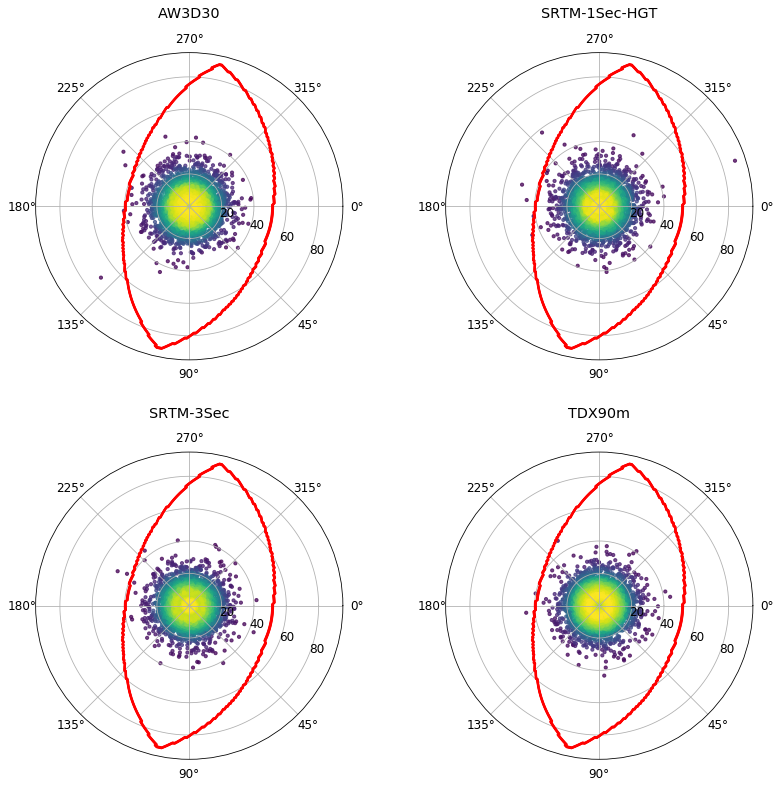

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from S1_ARD import dem_distribution
from spatialist import Raster, Vector
from spatialist.raster import rasterize

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13, 13)
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.titlepad'] = 20
plt.subplots_adjust(wspace=0.3, hspace=0.3)

incidence = id.meta['incidence']
heading = id.meta['heading']

print('heading: {}'.format(heading))
print('incidence: {}'.format(incidence))

i = 1
for dem_id, dem_file in demfiles_snap.items():
    print(dem_id)
    slope_file = dem_file.replace(dem_id, dem_id + '_slope')
    aspect_file = dem_file.replace(dem_id, dem_id + '_aspect')
    
    with Raster(slope_file) as ras:
        slope = ras.matrix()
    
    with Raster(aspect_file) as ras:
        aspect = ras.matrix()
    
    # create an on-the-fly water mask
    if site == 'Fiji':
        shp = os.path.join(maindir, 'SHP', 'fiji_vector.shp')
        with Vector(shp) as vec:
            with Raster(dem_file) as dem:
                with rasterize(vec, dem) as ras:
                    water = ras.matrix()
                    mask = np.isfinite(water)
    else:
        mask = None
    
    plt.subplot(2, 2, i, projection='polar')
    dem_distribution(slope, aspect, heading, incidence, nsamples=5000, title=dem_id, mask=mask)
    i += 1
outname = os.path.join(maindir.replace('data', 'figures'), '{}_DEM_polar.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

<a id='dem_diff'></a>
## plot the absolute difference of all DEM combinations
### stack the four DEMs into a 3D array

In [7]:
from spatialist import Raster

with Raster(list(demfiles_snap.values())) as ras:
    demstack = ras.array()

### plot the absolute difference

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


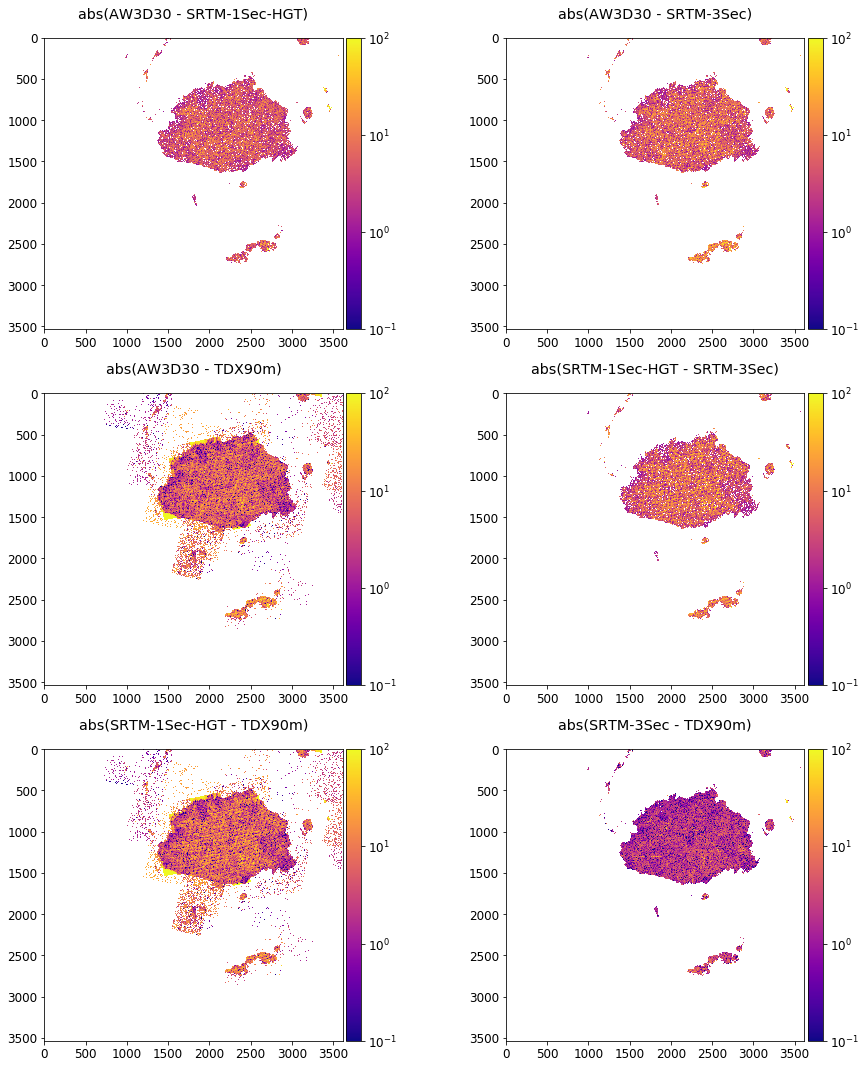

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13, 15)
matplotlib.rcParams['font.size'] = 12

comp_tuples = [(0, 1), # AW3D30,        SRTM-1Sec-HGT
               (0, 2), # AW3D30,        SRTM-3Sec
               (0, 3), # AW3D30,        TDX90m
               (1, 2), # SRTM-1Sec-HGT, SRTM-3Sec
               (1, 3), # SRTM-1Sec-HGT, TDX90m
               (2, 3)] # SRTM-3Sec,     TDX90m

fig, axes = plt.subplots(3, 2, num='absolute height difference [m]')
axes = axes.flatten()
dem_keys = list(demfiles_snap.keys())

i = 0
for dem1, dem2 in comp_tuples:
    
    diff = np.abs(demstack[:,:,dem1] - demstack[:,:,dem2])
    dem1_id = dem_keys[dem1]
    dem2_id = dem_keys[dem2]
    ax = axes[i]
    ax.set_title('abs({} - {})'.format(dem1_id, dem2_id))
    
    im = ax.imshow(diff, norm=LogNorm(), cmap='plasma', vmin=0.1, vmax=100.)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(ax.images[0], cax=cax)
    cbar.ax.minorticks_off()
    i += 1
plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_DEM_diff.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

### deviation from median

#### compute deviation

In [9]:
from spatialist import Raster
from S1_ARD.util import parallel_apply_along_axis

base = os.path.join(dem_dir, '{0}_dem_snap_{1}.tif')

maxdev_val = base.format(id.outname_base(), 'maxdev')
maxdev_ids = base.format(id.outname_base(), 'maxdev_id')

print(maxdev_val.replace(maindir, '.'))
print(maxdev_ids.replace(maindir, '.'))

if not os.path.isfile(maxdev_val) and not os.path.isfile(maxdev_ids):
    # function to compute maximum deviation and corresponding DEM ID
    def dev_max(arr):
        if len(arr[~np.isnan(arr)]) > 0:
            med = np.nanmedian(arr)
            absdev = abs(arr - med)
            maxdev = np.nanmax(absdev)
            if maxdev > 0:
                maxdev_id = np.nanargmax(absdev)
            else:
                maxdev_id = np.nan
            return maxdev, maxdev_id
        else:
            return np.nan, np.nan
    
    # execute function dev_max
    maxdev = parallel_apply_along_axis(func1d=dev_max, axis=2, arr=demstack, cores=4)

    # write the values to files using a DEM as geo reference
    ref = list(demfiles_snap.values())[0]
    with Raster(ref) as ras:
        ras.assign(maxdev[:, :, 0], 0)
        ras.write(maxdev_val, format='GTiff', nodata=-1, dtype='float32')
        ras.assign(maxdev[:, :, 1], 0)
        ras.write(maxdev_ids, format='GTiff', nodata=4, dtype='int8')
else:
    # simply load the files into an array if they already exist
    with Raster([maxdev_val, maxdev_ids]) as ras:
        maxdev = ras.array()

./DEM/S1A__IW___A_20181229T064000_dem_snap_maxdev.tif
./DEM/S1A__IW___A_20181229T064000_dem_snap_maxdev_id.tif


#### display of deviation maps

In [10]:
#  define image chips, which will be shown in a separate plot
if site == 'Alps':
    extents = [{'xmin': 900, 'xmax': 1400, 'ymin': 1950, 'ymax': 2450},
               {'xmin': 2200, 'xmax': 2500, 'ymin': 1300, 'ymax': 1600}]
else:
    extents = [{'xmin': 1350, 'xmax': 1650, 'ymin': 1350, 'ymax': 1650},
               {'xmin': 3100, 'xmax': 3500, 'ymin': 550, 'ymax': 950}]

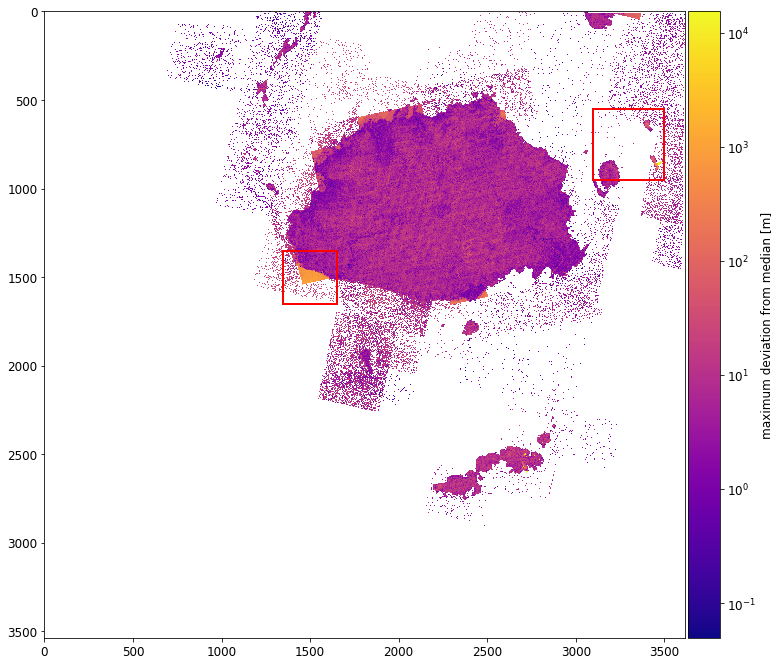

In [11]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 11)
matplotlib.rcParams['font.size'] = 12
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

plt.imshow(maxdev[:, :, 0], norm=LogNorm(), cmap='plasma', vmin=0.05)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(ax.images[0], cax=cax)
cbar.ax.minorticks_off()
cbar.set_label('maximum deviation from median [m]')

# Create a Rectangle patch
for extent in extents:
    xdiff = extent['xmax'] - extent['xmin']
    ydiff = extent['ymax'] - extent['ymin']
    rect = patches.Rectangle((extent['xmin'],extent['ymin']),
                             xdiff,ydiff,linewidth=2,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_DEM_maxdev.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

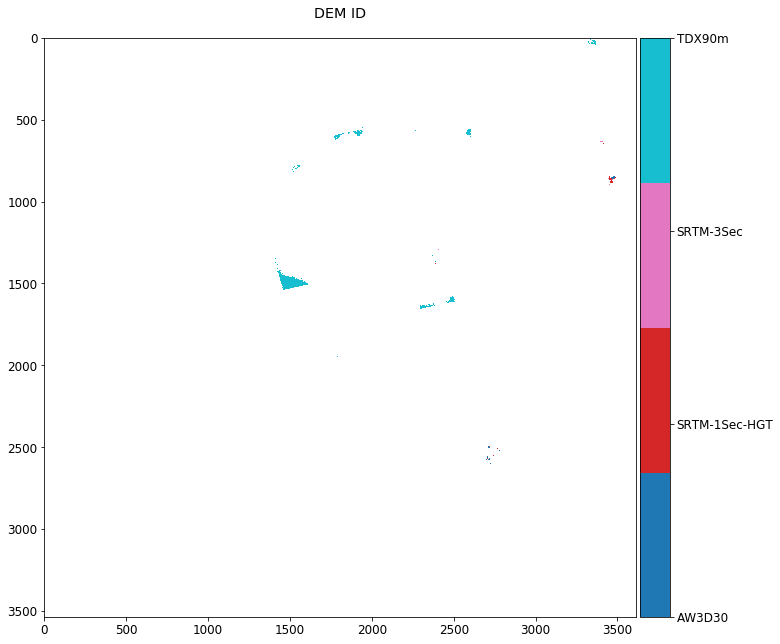

In [12]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 11)
matplotlib.rcParams['font.size'] = 12
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

with np.errstate(invalid='ignore'):
    ids = np.ma.masked_where(maxdev[:, :, 0] < 100, maxdev[:, :, 1])
plt.imshow(ids, cmap=plt.cm.get_cmap('tab10', 4))
ax = plt.gca()
ax.set_title('DEM ID')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(axes[1].images[0], cax=cax)
# cbar.ax.minorticks_off()
cb = plt.colorbar(ax.images[0], cax=cax, ticks=range(4))
cb.set_ticklabels(list(demfiles_snap.keys()))

plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_DEM_maxdev_id.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

#### display of deviation statistics

              ID     n     p50       p95
0            all  1783  441.08  13890.79
1         AW3D30   661  971.75  14913.00
2  SRTM-1Sec-HGT   881  630.50  10275.38
3      SRTM-3Sec   157  120.60    296.20
4         TDX90m    84  123.23    170.16


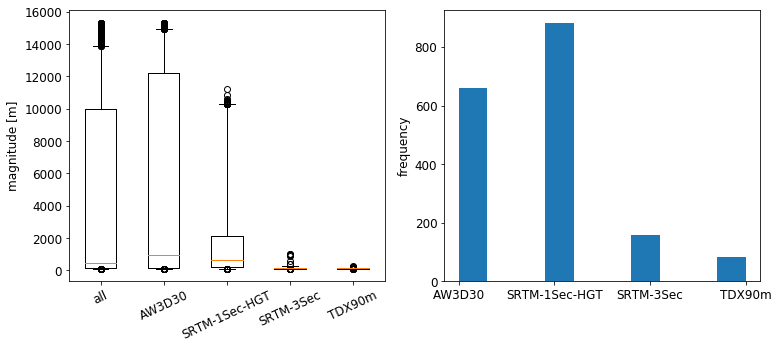

In [13]:
from S1_ARD.util import sampler
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 5)
matplotlib.rcParams['font.size'] = 12

nsamples = 10000

# only valid values and maxdev larger than 100
with np.errstate(invalid='ignore'):
    valmask = (~np.isnan(maxdev[:, :, 0])) & (maxdev[:, :, 0] > 100)

# create a water mask from the SRTM 3-Sec DEM
watermask = ~np.isnan(demstack[:, :, 2])

valmask = valmask & watermask

samplesize = []
samples = []

# overall deviation and frequency of IDs
sample_ids = sampler(valmask, nsamples=nsamples)
samplesize.append(len(sample_ids))
sample = maxdev[:, :, 0].flatten()[sample_ids]
samples.append(sample)
ids = maxdev[:, :, 1].flatten()[sample_ids]

# DEM-specific deviation
keys = list(demfiles_snap.keys())
for i in range(0, 4):
    mask = valmask & (maxdev[:, :, 1] == i)
    sample_ids = sampler(mask, nsamples=nsamples)
    samplesize.append(len(sample_ids))
    sample = maxdev[:, :, 0].flatten()[sample_ids]
    samples.append(sample)

labels = ['all'] + keys
p50 = [np.percentile(x, 50) for x in samples]
p95 = [np.percentile(x, 95) for x in samples]
summary = pd.DataFrame(data={'ID': labels, 'n': samplesize,
                             'p50': p50, 'p95': p95})
print(summary.round(2))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.ticklabel_format(style='plain')
# ax.set_yscale('log')
im = ax1.boxplot(samples, whis=[5, 95])
ax1.set_xticklabels(['all'] + keys)
for tick in ax1.get_xticklabels():
    tick.set_rotation(25)
ax1.set_ylabel('magnitude [m]')

sample_ids = sampler(valmask, nsamples=nsamples)
sample = maxdev[:, :, 0].flatten()[sample_ids]
ids = maxdev[:, :, 1].flatten()[sample_ids]
ax2.hist(ids)
ax2.set_xticks(range(4))
ax2.set_xticklabels(keys)
ax2.set_ylabel('frequency')

plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_DEM_stats.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

#### comparison of DEM image chips

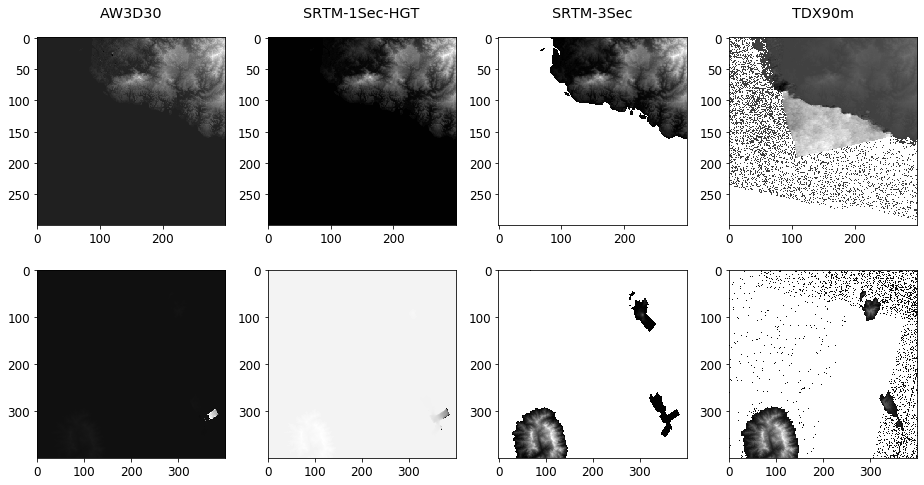

In [14]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13, 7)
matplotlib.rcParams['font.size'] = 12
from S1_ARD.util import dem_aspect

i = 0
for ext in extents:
    for j in range(0, 4):
        plt.subplot(2, 4, i + 1)
        sub = demstack[ext['ymin']:ext['ymax'], ext['xmin']:ext['xmax'], j]
        plt.imshow(sub, cmap='gray')
        if i < 4:
            plt.title(keys[i])
        i +=1

plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_DEM_chips.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

<a id='proc'></a>
# Processing

## Processing parameterization: GAMMA

In the following the SAR image is processed using the same DEM but with different coordinate reference systems, at different resolutions and with geoid conversion performed in GDAL and in GAMMA. This serves the purpose of assessing the impact of different setups on the quality of the topographic normalization.
Furthermore, once an optimal setup for preparing the DEM is found, the SAr images is processed with this particular DEM but different GAMMA interplation modes to again assess the impact of this choice on the final result.

### DEM preparation options

In [15]:
import os
from pyroSAR import identify
from pyroSAR.gamma import geocode
from pyroSAR.gamma.dem import dem_autocreate

if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

dem_dir = os.path.join(maindir, 'DEM')
if not os.path.isdir(dem_dir):
    os.makedirs(dem_dir)

# parallelize the Gamma commands
os.environ['OMP_NUM_THREADS'] = '6'

demType = 'SRTM 1Sec HGT'
dem_id = demType.replace(' ', '-')

# the DEM at 90m resolution in UTM was already prepared in prior steps
dem_base = '{}_dem_gamma_{}'.format(id.outname_base(), dem_id)
dem_utm_90 = os.path.join(dem_dir, dem_base)

# define a set of parameters shared between the different preparation processes 
dem_prep_args = {'geometry': id.bbox(),
                 'demType': demType,
                 'buffer': 0.1,
                 'username': 'username',
                 'password': 'password',
                 'geoid_mode': 'gdal'}

# prepare the DEM in 30 m resolution in WGS84 CRS, geoid correction in GDAL
dem_base = '{}_dem_gamma_{}_wgs84'.format(id.outname_base(), dem_id)
dem_wgs84_30 = os.path.join(dem_dir, dem_base)
if not os.path.isfile(dem_wgs84_30):
    print(dem_wgs84_30.replace(maindir, '.'))
    dem_prep_args['outfile'] = dem_wgs84_30
    
    dem_autocreate(**dem_prep_args)

# UTM 30 m, geoid correction in GDAL
dem_base = '{}_dem_gamma_{}_30m'.format(id.outname_base(), dem_id)
dem_utm_30 = os.path.join(dem_dir, dem_base)
if not os.path.isfile(dem_utm_30):
    print(dem_utm_30.replace(maindir, '.'))
    dem_prep_args['outfile'] = dem_utm_30
    dem_prep_args['t_srs'] = 32632
    dem_prep_args['tr'] = (30, 30)
    
    dem_autocreate(**dem_prep_args)

# UTM 30 m, geoid correction in GAMMA
dem_base = '{}_dem_gamma_{}_30m_gammageoid'.format(id.outname_base(), dem_id)
dem_utm_30_gamma = os.path.join(dem_dir, dem_base)
if not os.path.isfile(dem_utm_30_gamma):
    print(dem_utm_30_gamma.replace(maindir, '.'))
    dem_prep_args['outfile'] = dem_utm_30_gamma
    dem_prep_args['geoid_mode'] = 'gamma'
    
    dem_autocreate(**dem_prep_args)

# collect the DEM names for future use
demfiles = {'utm_30_gdal': dem_utm_30,
            'utm_30_gamma': dem_utm_30_gamma,
            'utm_90_gdal': dem_utm_90,
            'wgs84_30_gdal': dem_wgs84_30}

NotImplementedError: this analysis is for the Alps only

### process the reference scene with the different DEMs

In [16]:
if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

# a list for collecting identifiers of processed images
identifiers = []

# process images with DEM at different input resolution, CRS and geoid correction
geoback = 1
for dem_id_sub, dem in demfiles.items():
    identifier = '{}_gb{}'.format(dem_id_sub, geoback)
    scenedir = os.path.join(maindir, 'GAMMA', 'single',
                            '{}_{}_{}'.format(id.outname_base(), dem_id, identifier))
    identifiers.append(identifier)
    print(scenedir.replace(maindir, '.'))
    geocode(scene=id, dem=dem,
            tempdir=os.path.join(scenedir, 'process'),
            outdir=scenedir, targetres=90,
            scaling='db', func_geoback=geoback,
            export_extra=['inc_geo', 'ls_map_geo'])

NotImplementedError: this analysis is for the Alps only

### process the scene with only one DEM but different interpolation modes

In [17]:
if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

dem_id_sub = 'utm_90_gdal'
dem = dem_utm_90

for geoback in [2, 3, 4, 5]:
    identifier = '{}_gb{}'.format(dem_id_sub, geoback)
    scenedir = os.path.join(maindir, 'GAMMA', 'single',
                            '{}_{}_{}'.format(id.outname_base(), dem_id, identifier))
    identifiers.append(identifier)
    print(scenedir.replace(maindir, '.'))
    geocode(scene=id, dem=dem,
            tempdir=os.path.join(scenedir, 'process'),
            outdir=scenedir, targetres=90,
            scaling='db', func_geoback=geoback,
            export_extra=['inc_geo', 'ls_map_geo'])

NotImplementedError: this analysis is for the Alps only

### prepare CORINE layers for creating the forest mask

In [18]:
import os
from spatialist import Raster, gdalwarp
from spatialist.ancillary import finder
from spatialist.vector import intersect

from S1_ARD.util import clc_prep

clc = os.path.join(maindir, 'CORINE', 'clc2018_clc2018_V2018.20b2.tif')

patterns = {'GAMMA': 'VV_grd_mli_norm_geo_db.tif',
            'SNAP': 'VV_tnr_bnr_Orb_Cal_ML_TF_TC_dB.tif'}

for processor, pattern in patterns.items():
        images = finder(os.path.join(maindir, processor, 'single'), 
                     ['*{}'.format(pattern)])
        for image in images:
            clc_sub = image.replace(pattern, 'clc2018_V2018.20b2.tif')
            print(clc_sub.replace(maindir, '.'))
            clc_prep(clc=clc, reference=image, outname=clc_sub)
            print('-' * 10)

./GAMMA/single/S1A__IW___A_20180829T170656_AW3D30/S1A__IW___A_20180829T170656_clc2018_V2018.20b2.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20180829T170656_SRTM-1Sec-HGT/S1A__IW___A_20180829T170656_clc2018_V2018.20b2.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20180829T170656_SRTM-1Sec-HGT_utm_30_gamma_gb1/S1A__IW___A_20180829T170656_clc2018_V2018.20b2.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20180829T170656_SRTM-1Sec-HGT_utm_30_gdal_gb1/S1A__IW___A_20180829T170656_clc2018_V2018.20b2.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20180829T170656_SRTM-1Sec-HGT_utm_90_gdal_gb1/S1A__IW___A_20180829T170656_clc2018_V2018.20b2.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20180829T170656_SRTM-1Sec-HGT_utm_90_gdal_gb2/S1A__IW___A_20180829T170656_clc2018_V2018.20b2.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20180829T170656_SRTM-1Sec-HGT_utm_90_gdal_gb3/S1A__IW___A_20180

### visualize the results

In [19]:
if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

from S1_ARD.util import scatter
import matplotlib
import matplotlib.pyplot as plt
from spatialist import Raster, raster
import numpy as np

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['font.size'] = 12

xlim = (-5, 105)
ylim = (-30, 10)

dem_id = 'SRTM-1Sec-HGT'

i = 1
for identifier in identifiers:
    scenedir = os.path.join(maindir, 'GAMMA', 'single',
                            '{}_{}_{}'.format(id.outname_base(), dem_id, identifier))
    base = os.path.join(scenedir, id.outname_base())
    sar = base + '_VV_grd_mli_norm_geo_db.tif'
    inc = base + '_inc_geo.tif'
    clc = base + '_clc2018_V2018.20b2.tif'
    
    # slightly increase the tolerance to sub-pixel coordinate shifts
    raster.subset_tolerance = 0.002  # percent

    with Raster(sar) as ras:
        sar_mat = ras.matrix()
        
    # load the incident angle map
    with Raster(inc) as ras:
        inc_mat = ras.matrix()
        inc_mat = np.rad2deg(inc_mat)
    
    with Raster(clc) as ras:
        clc_mat = ras.matrix()
        forest = (clc_mat==311) | (clc_mat==312) | (clc_mat==313)

    plt.subplot(2, 4, i)
    scatter(inc_mat, sar_mat, nsamples=5000, title=identifier,
            mask=forest,
            xlab='Local Incident Angle [deg]',
            ylab=r'$\gamma^0$ [dB]',
            xlim=xlim, ylim=ylim,
            denscol=True, measures=['cv_y', 'eq'], regline=True)
    i += 1

plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_GAMMA_par.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

NotImplementedError: this analysis is for the Alps only

<a id='proc_gamma'></a>
## Processing using different DEMs: GAMMA

documentation:
- [pyroSAR.gamma.geocode](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.gamma.geocode)

Upon import the *gamma* submodule searches for an environement variable *GAMMA_HOME*, which needs to point to the main Gamma installation directory.

In [20]:
from pyroSAR import gamma

# parallelize the Gamma commands
os.environ['OMP_NUM_THREADS'] = '6'

for dem_id, dem_file in demfiles_gamma.items():
    scenedir = os.path.join(maindir, 'GAMMA', 'single', '{}_{}'.format(id.outname_base(), dem_id))
    print(scenedir.replace(maindir, '.'))
    gamma.geocode(scene=id, 
                  dem=dem_file,
                  tempdir=os.path.join(scenedir, 'process'), 
                  outdir=scenedir,
                  targetres=90, scaling='db', 
                  func_geoback=2, sarSimCC=False,
                  func_interp=2, normalization_method=2,
                  export_extra=['inc_geo', 'ls_map_geo', 'dem_seg_geo'])
    print('-' * 10)

./GAMMA/single/S1A__IW___A_20181229T064000_AW3D30
scene S1A__IW___A_20181229T064000 already processed
----------
./GAMMA/single/S1A__IW___A_20181229T064000_SRTM-1Sec-HGT
scene S1A__IW___A_20181229T064000 already processed
----------
./GAMMA/single/S1A__IW___A_20181229T064000_SRTM-3Sec
scene S1A__IW___A_20181229T064000 already processed
----------
./GAMMA/single/S1A__IW___A_20181229T064000_TDX90m
scene S1A__IW___A_20181229T064000 already processed
----------


<a id='proc_snap'></a>
## Processing using different DEMs: SNAP

documentation:
- [pyroSAR.snap.geocode](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.snap.util.geocode)

Upon import the *snap* submodule searches for the SNAP executables and relative to them for several sub-directories to identify the SNAP installation. For this, the SNAP *bin* sub-directory containing the binary executables needs to be contained in the PATH environment. This is best set in the .bashrc:
```shell
export PATH=$PATH:/path/to/snap/bin
```

In [21]:
from pyroSAR import snap

for dem_id, dem_file in demfiles_snap.items():
    scenedir = os.path.join(maindir, 'SNAP', 'single', '{}_{}'.format(id.outname_base(), dem_id))
    print(scenedir.replace(maindir, '.'))
    snap.geocode(infile=id,
                 externalDEMFile=dem_file,
                 externalDEMApplyEGM=False, t_srs=epsg,
                 outdir=scenedir, tr=90, scaling='db',
                 export_extra=['incidenceAngleFromEllipsoid',
                               'localIncidenceAngle',
                               'projectedLocalIncidenceAngle',
                               'DEM'], 
                 groupsize=1, # execute each node separately
                 gpt_exceptions={'Terrain-Flattening': snap5_gpt})
    print('-' * 10)

./SNAP/single/S1A__IW___A_20181229T064000_AW3D30
scene S1A__IW___A_20181229T064000 already processed
----------
./SNAP/single/S1A__IW___A_20181229T064000_SRTM-1Sec-HGT
scene S1A__IW___A_20181229T064000 already processed
----------
./SNAP/single/S1A__IW___A_20181229T064000_SRTM-3Sec
scene S1A__IW___A_20181229T064000 already processed
----------
./SNAP/single/S1A__IW___A_20181229T064000_TDX90m
scene S1A__IW___A_20181229T064000 already processed
----------


<a id='lulc'></a>
# Create LULC masks

<a id='corine'></a>
## Alps: Prepare CORINE Land Cover product

The product cannot be downloaded automatically but is available [here](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download) after registration.  
The product is reprojected and resampled to the exact size of respective SAR products for easier analysis.

documentation:
- [spatialist.Raster](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.raster.Raster)
- [spatialist.gdalwarp](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.auxil.gdalwarp)
- [spatialist.ancillary.finder](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.ancillary.finder)
- [spatialist.vector.intersect](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.vector.intersect)

In [22]:
import os
from spatialist import Raster, gdalwarp
from spatialist.ancillary import finder
from spatialist.vector import intersect

from S1_ARD.util import clc_prep

clc = os.path.join(maindir, 'CORINE', 'clc2018_clc2018_V2018.20b2.tif')

patterns = {'GAMMA': 'VV_grd_mli_norm_geo_db.tif',
            'SNAP': 'VV_tnr_bnr_Orb_Cal_ML_TF_TC_dB.tif'}

for processor, pattern in patterns.items():
    for dem_id in demfiles_gamma.keys():
        sar = finder(os.path.join(maindir, processor, 'single', 
                                  '{}_{}'.format(id.outname_base(), dem_id)), 
                     ['*{}'.format(pattern)])[0]
        
        clc_sub = sar.replace(pattern, 'clc2018_V2018.20b2.tif')
        print(clc_sub.replace(maindir, '.'))
        
        clc_prep(clc=clc, reference=sar, outname=clc_sub)
        print('-' * 10)

./GAMMA/single/S1A__IW___A_20181229T064000_AW3D30/S1A__IW___A_20181229T064000_clc2018_V2018.20b2.tif
no intersect
----------
./GAMMA/single/S1A__IW___A_20181229T064000_SRTM-1Sec-HGT/S1A__IW___A_20181229T064000_clc2018_V2018.20b2.tif
no intersect
----------
./GAMMA/single/S1A__IW___A_20181229T064000_SRTM-3Sec/S1A__IW___A_20181229T064000_clc2018_V2018.20b2.tif
no intersect
----------
./GAMMA/single/S1A__IW___A_20181229T064000_TDX90m/S1A__IW___A_20181229T064000_clc2018_V2018.20b2.tif
no intersect
----------
./SNAP/single/S1A__IW___A_20181229T064000_AW3D30/S1A__IW___A_20181229T064000_clc2018_V2018.20b2.tif
no intersect
----------
./SNAP/single/S1A__IW___A_20181229T064000_SRTM-1Sec-HGT/S1A__IW___A_20181229T064000_clc2018_V2018.20b2.tif
no intersect
----------
./SNAP/single/S1A__IW___A_20181229T064000_SRTM-3Sec/S1A__IW___A_20181229T064000_clc2018_V2018.20b2.tif
no intersect
----------
./SNAP/single/S1A__IW___A_20181229T064000_TDX90m/S1A__IW___A_20181229T064000_clc2018_V2018.20b2.tif
no inter

<a id='rasterize'></a>

## Fiji: rasterize forest mask from shapefile

documentation:
- [spatialist.raster.rasterize](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.raster.rasterize)
- [spatialist.Vector](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.vector.Vector)

In [23]:
import os
from spatialist import Raster, Vector, intersect, rasterize
from spatialist.ancillary import finder

shp = os.path.join(maindir, 'SHP', 'fiji_vector.shp')

patterns = {'GAMMA': 'VV_grd_mli_norm_geo_db.tif',
            'SNAP': 'VV_tnr_bnr_Orb_Cal_ML_TF_TC_dB.tif'}

for processor, pattern in patterns.items():
    for dem_id in demfiles_gamma.keys():
        sar = finder(os.path.join(maindir, processor, 'single',
                                  '{}_{}'.format(id.outname_base(), dem_id)),
                     ['*{}'.format(pattern)])[0]
        
        mask = sar.replace(pattern, 'mask_forest.tif')
        print(mask.replace(maindir, '.'))
        
        with Raster(sar).bbox() as box_ras:
            with Vector(shp).bbox() as box_clc:
                if intersect(box_ras, box_clc) is None:
                    print('no intersect\n' + '-' * 10)
                    continue

        if not os.path.isfile(mask):
            with Vector(shp) as vec:
                with Raster(sar) as ref:
                    rasterize(vectorobject=vec, reference=ref, outname=mask, 
                              expressions=["CLASS_NAME='Forest'"])
        else:
            print('outfile already exists')
        print('-' * 10)

./GAMMA/single/S1A__IW___A_20181229T064000_AW3D30/S1A__IW___A_20181229T064000_mask_forest.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20181229T064000_SRTM-1Sec-HGT/S1A__IW___A_20181229T064000_mask_forest.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20181229T064000_SRTM-3Sec/S1A__IW___A_20181229T064000_mask_forest.tif
outfile already exists
----------
./GAMMA/single/S1A__IW___A_20181229T064000_TDX90m/S1A__IW___A_20181229T064000_mask_forest.tif
outfile already exists
----------
./SNAP/single/S1A__IW___A_20181229T064000_AW3D30/S1A__IW___A_20181229T064000_mask_forest.tif
outfile already exists
----------
./SNAP/single/S1A__IW___A_20181229T064000_SRTM-1Sec-HGT/S1A__IW___A_20181229T064000_mask_forest.tif
outfile already exists
----------
./SNAP/single/S1A__IW___A_20181229T064000_SRTM-3Sec/S1A__IW___A_20181229T064000_mask_forest.tif
outfile already exists
----------
./SNAP/single/S1A__IW___A_20181229T064000_TDX90m/S1A__IW___A_20181229T064000_mask_fores

<a id='sar_inc'></a>
# Comparison of backscatter with local angle of incidence

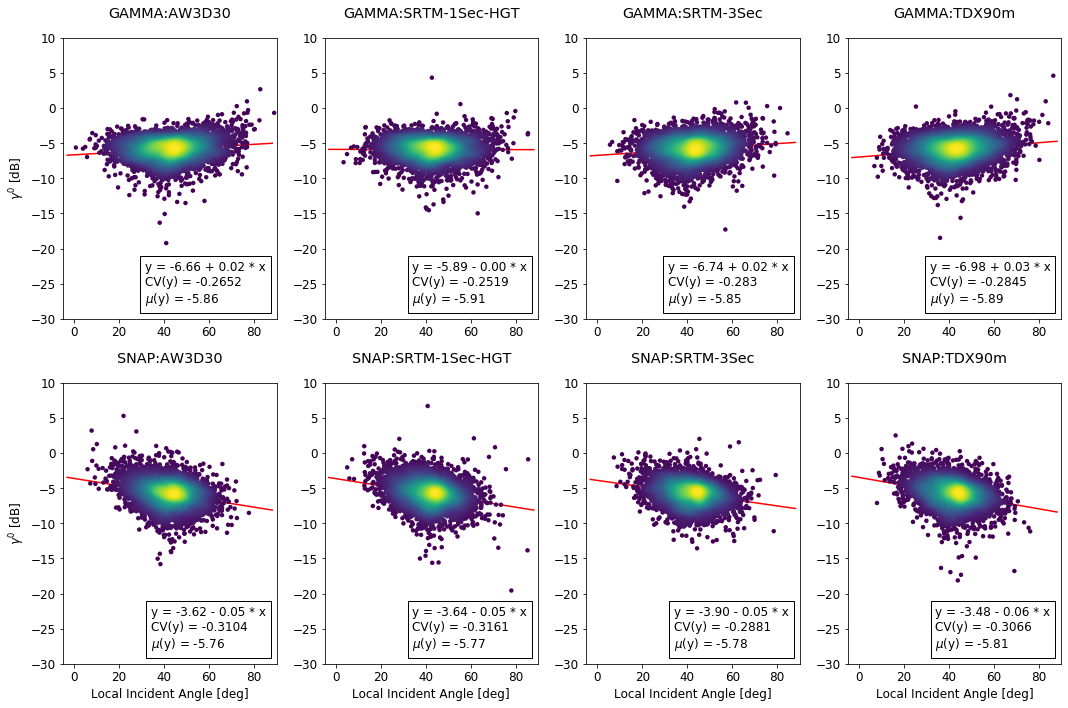

In [24]:
import numpy as np
from S1_ARD import scatter
from matplotlib import pyplot as plt
import matplotlib
from spatialist import Raster, raster

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['font.size'] = 12
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# select the source of the local incident angle map; either the SMALL product or that produced together 
# with the SAR scene by the respective processor is used
inc_choice = 'processor'
# inc_choice = 'small'

# define the plot's value range of x and y
# the SMALL product contains values below 0, the SNAP and GAMMA products don't
ylim = (-30, 10)
if inc_choice == 'small':
    xlim = (-25, 90)
else:
    xlim = (-5, 90)

i = 1
for software in ['GAMMA', 'SNAP']:
    
    # use SMALL INC product
    if inc_choice == 'small':
        radian_convert = False
        if software == 'GAMMA':
            inc = os.path.join(maindir, 'INC', 'small.tif')
        else:
            inc = os.path.join(maindir, 'INC', 'small_snapgrid.tif')
    
    for dem_id in demfiles_gamma.keys():
        scenedir = os.path.join(maindir, software, 'single', 
                                '{}_{}'.format(id.outname_base(), dem_id))
        if software == 'GAMMA':
            sar = os.path.join(scenedir, '{}_VV_grd_mli_norm_geo_db.tif'.format(id.outname_base()))
            if inc_choice == 'processor':
                inc = os.path.join(scenedir, '{}_inc_geo.tif'.format(id.outname_base()))
                radian_convert = True
        else:
            sar = os.path.join(scenedir, '{}_VV_tnr_bnr_Orb_Cal_ML_TF_TC_dB.tif'.format(id.outname_base()))
            if inc_choice == 'processor':
                inc = os.path.join(scenedir, '{}_localIncidenceAngle.tif'.format(id.outname_base()))
                radian_convert = False
        
        clc = os.path.join(scenedir, '{}_clc2018_V2018.20b2.tif'.format(id.outname_base()))
        fmask = os.path.join(scenedir, '{}_mask_forest.tif'.format(id.outname_base()))
        
        if os.path.isfile(clc):
            with Raster(clc) as ras:
                clc_mat = ras.matrix()
            
            # 311: Broad-leaved forest
            # 312: Coniferous forest
            # 313: Mixed forest
            forest = (clc_mat==311) | (clc_mat==312) | (clc_mat==313)
        
        elif os.path.isfile(fmask):
            with Raster(fmask) as ras:
                mat = ras.matrix()
            forest = ~np.isnan(mat)
        else:
            raise RuntimeError('did not find file for masking forest')
        
        with Raster(sar) as ras:
            sar_mat = ras.matrix()
        
        # slightly increase the tolerance to sub-pixel coordinate shifts
        raster.subset_tolerance = 0.002  # percent
        
        # load the inc product subsetted to the extent of the SAR image
        with Raster(sar) as ref:
            with Raster(inc)[ref.bbox()] as ras:
                inc_mat = ras.matrix()
        
        # if necessary, convert the inc product from radians to degrees
        if radian_convert:
            inc_mat = np.rad2deg(inc_mat)
        
        plt.subplot(2, 4, i)
        
        # add the y label only to the first plot pf each row
        if i in [1, 5]:
            ylab = r'$\gamma^0$ [dB]'
        else:
            ylab = None
        
        # add the x label onl to the plots in the bottom row
        if i > 4:
            xlab = 'Local Incident Angle [deg]'
        else:
            xlab = None
        
        scatter(inc_mat, sar_mat, nsamples=5000, title='{}:{}'.format(software, dem_id),
                mask=forest,
                xlab=xlab, ylab=ylab,
                xlim=xlim, ylim=ylim,
                denscol=True, measures=['cv_y', 'eq', 'mean_y'], regline=True)
        i += 1
plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_SAR-INC.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

<a id='snap_tf'></a>
# Comparison of SNAP results

## process image without terrain flattening

In [4]:
if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

from pyroSAR import snap

dem_id = 'SRTM-1Sec-HGT'
dem_file = demfiles_snap[dem_id]

scenedir = os.path.join(maindir, 'SNAP', 'single', '{}_{}'.format(id.outname_base(), dem_id + '_no-tf'))
print(scenedir.replace(maindir, '.'))
snap.geocode(infile=id,
             externalDEMFile=dem_file,
             externalDEMApplyEGM=False, t_srs=epsg,
             outdir=scenedir, tr=90, scaling='db',
             export_extra=['incidenceAngleFromEllipsoid',
                           'localIncidenceAngle',
                           'projectedLocalIncidenceAngle',
                           'DEM'], groupsize=1,
             terrainFlattening=False,
             gpt_exceptions={'Terrain-Flattening': snap5_gpt})

./SNAP/single/S1A__IW___A_20180829T170656_SRTM-1Sec-HGT_no-tf
scene S1A__IW___A_20180829T170656 already processed


## process image with SRTM auto-download and SNAP6

In [5]:
if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

scenedir = os.path.join(maindir, 'SNAP', 'single', '{}_{}'.format(id.outname_base(), dem_id + '_auto'))
print(scenedir.replace(maindir, '.'))
snap.geocode(infile=id, t_srs=epsg,
             outdir=scenedir, tr=90, scaling='db',
             export_extra=['incidenceAngleFromEllipsoid',
                           'localIncidenceAngle',
                           'projectedLocalIncidenceAngle',
                           'DEM'], groupsize=1,test=False,
             terrainFlattening=True)

./SNAP/single/S1A__IW___A_20180829T170656_SRTM-1Sec-HGT_auto
scene S1A__IW___A_20180829T170656 already processed


## plot the results

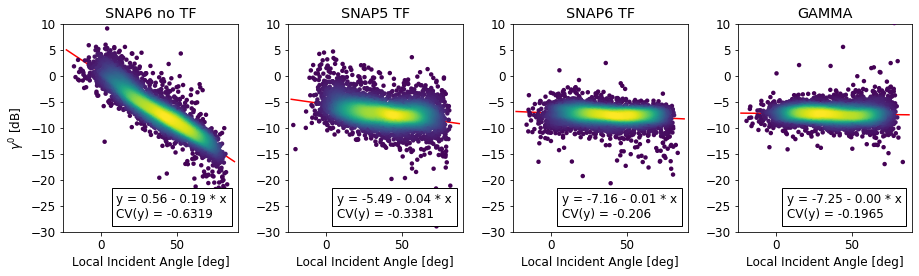

In [12]:
if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

from spatialist import Raster, raster
import matplotlib.pyplot as plt
from S1_ARD.util import scatter
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13, 4)
matplotlib.rcParams['font.size'] = 12
plt.subplots_adjust(wspace=0.3, hspace=0.3)

xlim = (-25, 90)
ylim = (-30, 10)

dem_id = 'SRTM-1Sec-HGT'

base = os.path.join(maindir, 'SNAP', 'single', '{}_{}'.format(id.outname_base(), dem_id))
titles = ['SNAP6 no TF', 'SNAP5 TF', 'SNAP6 TF']
for i, option in enumerate(['_no-tf', '', '_auto']):
    scenedir = base + option
    snap = os.path.join(scenedir, 
                       '{0}_VV_tnr_bnr_Orb_Cal_ML{1}_TC_dB.tif'
                       .format(id.outname_base(), '' if i ==0 else '_TF'))
    inc = os.path.join(maindir, 'INC', 'small.tif')
    with Raster(snap) as ras:
        snap_mat = ras.matrix()
    
    with Raster(snap) as ref:
        with Raster(inc)[ref.bbox()] as ras:
            inc_mat = ras.matrix()[1:,1:]
    
    clc_sub = os.path.join(scenedir, '{}_clc2018_V2018.20b2.tif'.format(id.outname_base()))
    
    if not os.path.isfile(clc_sub):
        print('creating CLC subset')
        clc = os.path.join(maindir, 'CORINE', 'clc2018_clc2018_V2018.20b2.tif')
        clc_prep(clc, snap, clc_sub)
    
    with Raster(clc_sub) as ras:
        clc_mat = ras.matrix()
    
    # 311: Broad-leaved forest
    # 312: Coniferous forest
    # 313: Mixed forest
    forest = (clc_mat==311) | (clc_mat==312) | (clc_mat==313)
    
    
    plt.subplot(1, 4, i + 1)
    
    # alternatively plot the masked backscatter
#     sar_mat[sar_mat == -99] = np.nan
#     sar_mat[~clc_mask] = np.nan
#     plt.imshow(sar_mat)
    if i == 0:
        ylab = r'$\gamma^0$ [dB]'
    else:
        ylab = None

    xlab = 'Local Incident Angle [deg]'
    
    scatter(inc_mat, snap_mat, nsamples=5000, title=titles[i],
            xlab=xlab, ylab=ylab, mask=forest,
            xlim=xlim, ylim=ylim,
            denscol=True, measures=['cv_y', 'eq'], regline=True)

i = 3

base = os.path.join(maindir, 'GAMMA', 'single', '{}_{}'.format(id.outname_base(), dem_id))
gamma = os.path.join(base, 
                   '{0}_VV_grd_mli_norm_geo_db.tif'
                   .format(id.outname_base()))

inc = os.path.join(maindir, 'INC', 'small.tif')

with Raster(gamma) as ras:
    gamma_mat = ras.matrix()

# slightly increase the tolerance to sub-pixel coordinate shifts
raster.subset_tolerance = 0.002  # percent

with Raster(gamma) as ref:
    with Raster(inc)[ref.bbox()] as ras:
        inc_mat = ras.matrix()

clc_sub = os.path.join(base, '{}_clc2018_V2018.20b2.tif'.format(id.outname_base()))

if not os.path.isfile(clc_sub):
    print('creating CLC subset')
    clc = os.path.join(maindir, 'CORINE', 'clc2018_clc2018_V2018.20b2.tif')
    clc_prep(clc, gamma, clc_sub)

with Raster(clc_sub) as ras:
    clc_mat = ras.matrix()

# 311: Broad-leaved forest
# 312: Coniferous forest
# 313: Mixed forest
forest = (clc_mat==311) | (clc_mat==312) | (clc_mat==313)

plt.subplot(1, 4, i + 1)

scatter(inc_mat, gamma_mat, nsamples=5000, title='GAMMA',
        xlab=xlab, ylab=ylab, mask=forest,
        xlim=xlim, ylim=ylim,
        denscol=True, measures=['cv_y', 'eq'], regline=True)

plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_SNAP-TF.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

<a id='snap_gamma_terrain'></a>
# direct comparsion of GAMMA and SNAP by terrain

   inc. angle  RMSE all SNAP5  RMSE all SNAP6  RMSE forest
0    >-20--10            4.02            2.45         2.22
1      >-10-0            4.93            2.49         2.26
2       >0-10            4.10            2.36         1.96
3      >10-20            3.31            2.19         1.77
4      >20-30            2.54            2.15         1.68
5      >30-40            3.09            2.31         1.70
6      >40-50            2.67            1.99         1.74
7      >50-60            2.69            2.06         1.76
8      >60-70            3.24            2.53         2.09
9      >70-80            4.38            3.30         3.14
10     >80-90            5.79            4.62         4.46


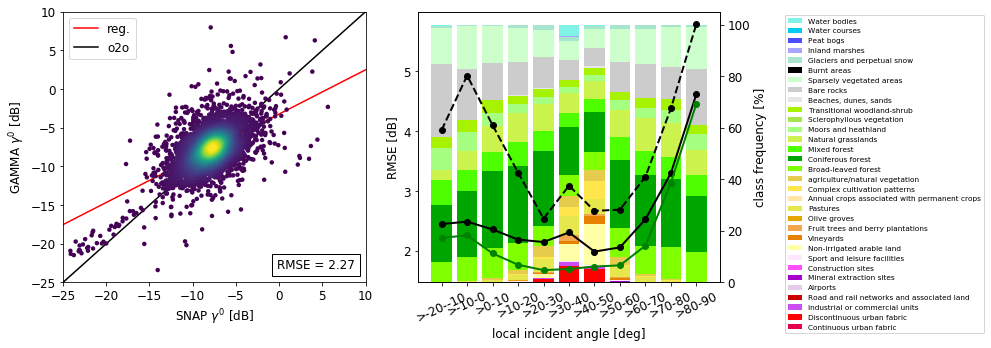

In [22]:
if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

import os
import math
import numpy as np
import pandas as pd
from spatialist import Raster, bbox
from S1_ARD.util import commonextent, scatter, sampler, clc_legend
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14, 5)
matplotlib.rcParams['font.size'] = 12
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# define file names for a selected DEM and SAR scene
base = 'S1A__IW___A_20180829T170656'
dem_id = 'SRTM-1Sec-HGT'

snap_file = os.path.join(maindir, 'SNAP', 'single', '{}_{}_auto'.format(base, dem_id),
                         '{}_VV_tnr_bnr_Orb_Cal_ML_TF_TC_dB.tif'.format(base))

snap5_file = os.path.join(maindir, 'SNAP', 'single', '{}_{}'.format(base, dem_id),
                         '{}_VV_tnr_bnr_Orb_Cal_ML_TF_TC_dB.tif'.format(base))

gamma_file = os.path.join(maindir, 'GAMMA', 'single', '{}_{}'.format(base, dem_id),
                          '{}_VV_grd_mli_norm_geo_db.tif'.format(base))

corine_file = os.path.join(maindir, 'GAMMA', 'single', '{}_{}'.format(base, dem_id),
                           '{}_clc2018_V2018.20b2.tif'.format(base))

# ue the GAMMA INC product for terrain stratification
# terrain_file = os.path.join(maindir, 'GAMMA', 'single', '{}_{}'.format(base, dem_id),
#                         '{}_inc_geo.tif'.format(base))
# radian_convert = True

# alternatively use the SMALL INC product
terrain_file = os.path.join(maindir, 'INC', 'small.tif')
radian_convert = False

# alternatively use the DEM slope
# terrain_file = os.path.join(maindir, 'DEM', '{}_dem_snap_{}_slope.tif'.format(base, dem_id))
# radian_convert = False

# create a common extent dictionary for subsetting the respective image files
with Raster(snap_file) as ras1:
    with Raster(gamma_file) as ras2:
        with ras1.bbox() as box1:
            with ras2.bbox() as box2:
                ext = commonextent(*[box1.extent, box2.extent])

# read the image files
with bbox(ext, crs=epsg) as box:
    with Raster(snap_file)[box] as ras:
        snap = ras.matrix()
    
    with Raster(snap5_file)[box] as ras:
        snap5 = ras.matrix()
        
    with Raster(gamma_file)[box] as ras:
        gamma = ras.matrix()[0:2439, 0:3216]  # the SNAP files are larger by one pixel
    
    # use the local incident angle for terrain stratification
    terrain_label = 'local incident angle [deg]'
    with Raster(terrain_file)[box] as ras:
        terrain = ras.matrix()[0:2439, 0:3216]
        if radian_convert:
            terrain = np.rad2deg(terrain)
    
    # alternatively use the local incident angle for terrain stratification
    # terrain_label = 'slope [deg]'
    # with Raster(slope_file)[box] as ras:
    #     terrain = ras.matrix()[0:2439, 0:3216]
    
    with Raster(corine_file)[box] as ras:
        clc = ras.matrix()[0:2439, 0:3216]

nanmask = (np.isfinite(snap)) & (np.isfinite(gamma))& (np.isfinite(snap5))

# create  SNAP vs. SAR scatter plot without any terrain masking
plt.subplot(1, 2, 1)
scatter(snap, gamma, mask=nanmask, nsamples=5000, xlab=r'SNAP $\gamma^0$ [dB]', ylab=r'GAMMA $\gamma^0$ [dB]', 
        o2o=True, regline=True, denscol=True, xlim=(-25, 10), ylim=(-25, 10), measures=['rmse'], legend=True)

lower = int(10 * round(np.nanmin(terrain) / 10))  # the lower boundary of the terrain range
lower_collect = []  # a list for storing all accepted terrain ranges for labeling
maxval = np.nanmax(terrain)  # the maximum terrain value
nsamples = 2500  # the number of samples required for each terrain range to be plotted
result = []  # the list of RMSE values for the respective terrain ranges
result_forest = []  # the RMSE list for the forest samples
result_snap5 = []  # RMSE values of SNAP5 vs. GAMMA
classes = []  # a list of unique classes collected from the samples
stats = []  # a list to collect tuples of (classname, frequency of occurence)

# the forest mask with all combined CLC forest sub-classes
forest = (clc==311) | (clc==312) | (clc==313)

# mask by certain terrain ranges as long as enough samples are found
while True:
    # break the loop if the lower end of the current terrain range is 
    # higher than the highest terrain value
    if lower > maxval:
        break
    
    # create mask of current terrain range
    with np.errstate(invalid='ignore'):
        mask = nanmask & (lower < terrain) & (terrain <= lower + 10)
    
    # create additional mask limited to forested areas
    mask_forest = mask & forest
    
    # draft the two sets of sample IDs
    sample_ids = sampler(mask, nsamples=nsamples)
    sample_ids_forest = sampler(mask_forest, nsamples=nsamples)
    
    # break if not enough samples are found for the current terrain range
    size = len(sample_ids)
    if size < nsamples:
        lower += 10
        continue
    
    lower_collect.append(lower)
    
    # create the samples from the ID sets
    x = snap.flatten()[sample_ids]
    x_snap5 = snap5.flatten()[sample_ids]
    y = gamma.flatten()[sample_ids]
    lulc = clc.flatten()[sample_ids]
    
    x_forest = snap.flatten()[sample_ids_forest]
    y_forest = gamma.flatten()[sample_ids_forest]
    
    # collect class occurrences
    unique, counts = np.unique(lulc, return_counts=True)
    percentage = counts / np.sum(counts) * 100
    stats.append(dict(zip([str(int(x)) for x in unique], percentage)))
    classes.extend(unique)
    
    # compute the RMSE between the SAR images for samples of the selected terrain range
    rmse = round(math.sqrt(mean_squared_error(x, y)), 2)
    result.append(rmse)
    
    # compute RMSE for forest samples
    rmse_forest = round(math.sqrt(mean_squared_error(x_forest, y_forest)), 2)
    result_forest.append(rmse_forest)
    
    # compute RMSE for snap5 vs. gamma samples
    rmse_snap5 = round(math.sqrt(mean_squared_error(x_snap5, y)), 2)
    result_snap5.append(rmse_snap5)
    
    # increment the lower boundary of the terrain range
    lower += 10

# collect all unique classes
classes = sorted(list(set(classes)))
classes_str = [str(int(x)) for x in classes]
# ad a frequency of 0 for all classes that did not occur in a sample
for item in stats:
    for c in classes_str:
        if c not in item.keys():
            item[c] = 0

#  plot the RMSE values
plt.subplot(1, 2, 2)
ax = plt.gca()
ax.plot(range(0, len(result)), result, '-o', linewidth=2, color='black')
ax.plot(range(0, len(result_forest)), result_forest, '-o', linewidth=2, color='green')
ax.plot(range(0, len(result_snap5)), result_snap5, '--o', linewidth=2, color='black')
plt.xlabel(terrain_label)
plt.ylabel('RMSE [dB]')
labels = ['>{}-{}'.format(x, x + 10) for x in lower_collect]
ax.set_xticklabels(labels)
for tick in ax.get_xticklabels():
    tick.set_rotation(25)
ax.set_xticks(range(len(result)))

summary = pd.DataFrame(data={'inc. angle': labels,
                             'RMSE all SNAP5': result_snap5,
                             'RMSE all SNAP6': result,
                             'RMSE forest': result_forest})
print(summary)

# read CLC legend CSV file for class names and color code
legend = os.path.join(maindir, 'CORINE', 'clc_legend.csv')
clc_meta = clc_legend(legend)

# add a new plot with a second y-axis and place it behind the existing one
ax2 = ax.twinx()
ax.set_zorder(ax2.get_zorder() + 1)  # put ax in front of ax2
ax.patch.set_visible(False)  # hide the 'canvas'

# create bar plot for each CLC class and terrain class; the CLC classes are stacked
agg = None  # the aggregated values of each bar
for c in classes_str:
    ds = [x[c] for x in stats]
    id = clc_meta['CLC_CODE'].index(c)
    
    # get the color from the legend info
    color = clc_meta['RGB'][id]
    
    # the long class description for the legend
    if c == '243':
        cl = 'agriculture/natural vegetation'
    else:
        cl = clc_meta['LABEL3'][id]
    
    if agg is None:
        p1 = ax2.bar(x=range(len(ds)), height=ds, color=color, label=cl)
        agg = np.array(ds)
    else:
        p1 = ax2.bar(x=range(len(ds)), height=ds, bottom=agg, color=color, label=cl)
        agg = agg + np.array(ds)

plt.ylabel('class frequency [%]')

# make room for the legend
box = ax2.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])
ax2.set_position([box.x0, box.y0, box.width * 0.5, box.height])
legend_x = 1.2
legend_y = 0.4

# add the legend to the right of the second plot
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], fontsize=7.4, 
           loc='center left', bbox_to_anchor=(legend_x, legend_y))

plt.tight_layout(rect=[0, 0, 0.8, 1])
outname = os.path.join(maindir.replace('data', 'figures'), '{}_RMSE_terrain.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

<a id='inc_comp'></a>
# Comparison of local incident angle maps

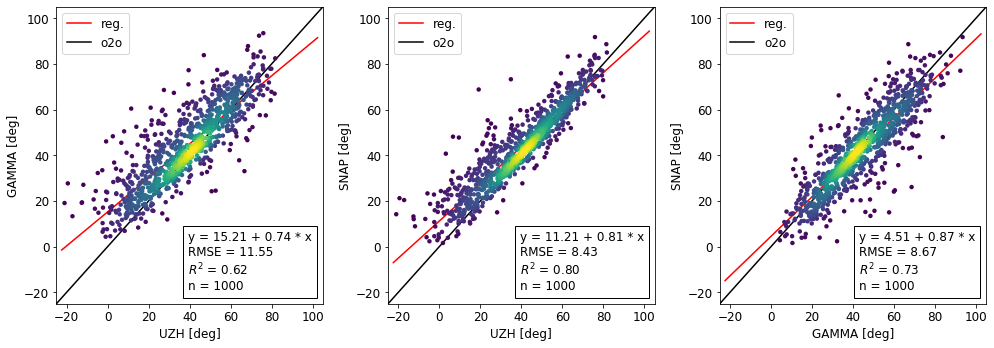

In [8]:
if site == 'Fiji':
    raise NotImplementedError('this analysis is for the Alps only')

import os
import numpy as np
from spatialist import Raster

from S1_ARD.util import scatter, inc_stack

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14, 5)
matplotlib.rcParams['font.size'] = 12
plt.subplots_adjust(wspace=0.3, hspace=0.3)

inc_small = os.path.join(maindir, 'SMALL', 'GRDH-IW-20180829_170656-023464-r3_gc30-lim-utm.tif')
inc_gamma = os.path.join(maindir, 'GAMMA', 'single', 'S1A__IW___A_20180829T170656_AW3D30',
                         'S1A__IW___A_20180829T170656_inc_geo.tif')
inc_snap = os.path.join(maindir, 'SNAP', 'single', 'S1A__IW___A_20180829T170656_AW3D30',
                        'S1A__IW___A_20180829T170656_localIncidenceAngle.tif')

outnames = inc_stack(small=inc_small, gamma=inc_gamma, snap=inc_snap,
                     outdir=os.path.join(maindir, 'INC'),
                     prefix='S1A__IW___A_20180829T170656_inc_')

with Raster(outnames) as ras:
    arr = ras.array()

mask = (np.isfinite(arr[:, :, 0])) & (np.isfinite(arr[:, :, 1])) & (np.isfinite(arr[:, :, 2]))

measures = ['eq', 'rmse', 'r2', 'n']
xlim = (-25, 105)
ylim = (-25, 105)

plt.subplot(1, 3, 1)
scatter(arr[:, :, 0], arr[:, :, 1], mask=mask, measures=measures, regline=True, o2o=True,
        xlab='UZH [deg]', ylab='GAMMA [deg]', denscol=True, xlim=xlim, ylim=ylim, legend=True)

plt.subplot(1, 3, 2)
scatter(arr[:, :, 0], arr[:, :, 2], mask=mask, measures=measures, regline=True, o2o=True,
        xlab='UZH [deg]', ylab='SNAP [deg]', denscol=True, xlim=xlim, ylim=ylim, legend=True)

plt.subplot(1, 3, 3)
scatter(arr[:, :, 1], arr[:, :, 2], mask=mask, measures=measures, regline=True, o2o=True,
        xlab='GAMMA [deg]', ylab='SNAP [deg]', denscol=True, xlim=xlim, ylim=ylim, legend=True)

plt.tight_layout()
outname = os.path.join(maindir.replace('data', 'figures'), '{}_INC_compare.png'.format(site))
plt.savefig(outname, dpi=300, format='png', bbox_inches='tight')
plt.show()

<a id='todo'></a>
# TODO

- SNAP processing
  * [x] enable writing ancillary products
- GAMMA processing
  * do processing in very steep terrain with different scene (negative incidence angles?)
- DEM comparison
  * [x] implementation of functions to derive aspect and slope for better visualization
  * [x] visualize artifacts in e.g. steep terrain
  * [x] visualize height bias from e.g. lack of ground reference points in photogrammetric DEMs
  * [x] finish implementation of Cristian's plotting function
- comparison SNAP vs. Gamma
  * compare ancillary products
    + [x] DEM after EGM correction
    + [x] local incident angle
  * [x] SAR backscatter before and after normalization
  * [x] comparability in flat terrain
- comparison ascending vs. descending
  * [ ] select and process scene from descending orbit


# Download additional SAR data
## write the search box from the Copernicus Hub to a file

In [ ]:
import os
from S1_ARD.util import wkt2shp

name_shp = os.path.join(maindir, 'SHP', 'testsite_alps.shp')

srs = 4326

wkt = 'POLYGON((' \
      '9.302927378921362 46.20802310382879,' \
      '10.63255440957775 46.20802310382879,' \
      '10.63255440957775 47.156898692795124,' \
      '9.302927378921362 47.156898692795124,' \
      '9.302927378921362 46.20802310382879))'

if not os.path.isfile(name_shp):
    wkt2shp(wkt, srs, name_shp)

## search Copernicus Hub for Sentinel-1 scenes
Eight scenes overlapping with the seach box acquired between Aug. 25 and Aug. 30 2018 currently exist. Two for each combination S1A + S1B, Ascending + Descending. All scenes will be processes and the two scenes acquired directly after each other will be mosaiced. One of the scenes was already downloaded for the earlier analyses.  
For bulk download the [esa_sentinel](https://github.com/johntruckenbrodt/esa_sentinel) tool needs to be installed:  
```shell
python3 -m pip install git+https://github.com/johntruckenbrodt/esa_sentinel.git
```

In [ ]:
import sentinel_api as api

# use username and password for ESA DATA Hub authentication
username = 'username'
password = 'password'

s1 = api.SentinelDownloader(username, password, api_url='https://scihub.copernicus.eu/apihub/')

s1.set_download_dir(os.path.join(maindir, 'S1'))

# load geometries from shapefile
s1.load_sites(name_shp)

# search for scenes with some restrictions (e.g., minimum overlap 1%)
for platform in ['S1A*', 'S1B*']:
    s1.search(platform, min_overlap=0.01, start_date='2018-08-25', end_date='2018-08-30',
              date_type='beginPosition', productType='GRD',
              sensoroperationalmode='IW')

s1.print_scenes()

## download the scenes

In [ ]:
s1.download_all()

# prepare DEMs from Alps test site

In [ ]:
import re
from pyroSAR.auxdata import dem_autoload, dem_create
from pyroSAR.gamma import par2hdr
from pyroSAR.gamma.api import diff
from spatialist import gdalwarp, Vector

site_file = os.path.join(maindir, 'SHP', 'testsite_alps.shp')

demType = 'AW3D30'
dem_id = demType.replace(' ', '-')
dem_base = 'alps_dem_snap_{}'.format(dem_id)
dem_dir = os.path.join(maindir, 'DEM')
if not os.path.isdir(dem_dir):
    os.makedirs(dem_dir)
dem_snap = os.path.join(dem_dir, dem_base + '.tif')
print(dem_snap.replace(maindir, '.'))
if not os.path.isfile(dem_snap):
    with Vector(site_file) as site:
        vrt = dem_autoload(geometries=[site], 
                           demType=demType,
                           vrt='/vsimem/{}.vrt'.format(dem_base), 
                           buffer=0.1)
    # create a DEM GTiff file from the VRT
    dem_create(src=vrt, dst=dem_snap, t_srs=epsg, tr=(20, 20), geoid_convert=True)

dem_base = 'alps_dem_gamma_{}'.format(dem_id)
dem_gamma = os.path.join(dem_dir, dem_base)
print(dem_gamma.replace(maindir, '.'))
if not os.path.isfile(dem_gamma):
    inlist = ['UTM', 'WGS84', 1, 32, 0, os.path.basename(dem_gamma), '', '', '', '', '',
              '-{0} {0}'.format(20), '']
    parfile = dem_gamma + '.par'
    if not os.path.isfile(parfile):
        diff.create_dem_par(DEM_par=parfile,
                            inlist=inlist)
    diff.dem_import(input_DEM=dem_snap,
                    DEM=dem_gamma,
                    DEM_par=parfile)
    par2hdr(parfile, parfile.replace('.par', '.hdr'))

# Process scenes for Alps test site with SNAP

In [ ]:
from pyroSAR import snap
from spatialist.ancillary import finder

scenes = finder(os.path.join(maindir, 'S1'), ['S1*zip'])

scenedir = os.path.join(maindir, 'SNAP', 'stack')
for scene in scenes:
    print(os.path.basename(scene))
    snap.geocode(infile=scene,
                 externalDEMFile=dem_snap, shapefile=site_file,
                 externalDEMApplyEGM=False, t_srs=epsg,
                 outdir=scenedir, tr=20, scaling='db', groupsize=1,
                 export_extra=['incidenceAngleFromEllipsoid',
                               'localIncidenceAngle',
                               'projectedLocalIncidenceAngle',
                               'DEM'],
                 gpt_exceptions={'Terrain-Flattening': snap5_gpt})
    print('-' * 10)

# Process scenes for Alps test site with GAMMA

In [ ]:
from pyroSAR import gamma
from spatialist.ancillary import finder

scenes = finder(os.path.join(maindir, 'S1'), ['S1*zip'])

scenedir = os.path.join(maindir, 'GAMMA', 'stack')

for scene in scenes:
    print(os.path.basename(scene))
    gamma.geocode(scene=scene, 
                  dem=dem_gamma,
                  tempdir=os.path.join(scenedir, 'process'), 
                  outdir=scenedir,
                  targetres=20, 
                  scaling='db', 
                  export_extra=['inc_geo', 'ls_map_geo'])
    print('-' * 10)

In [ ]:
from pyroSAR.ancillary import find_datasets, groupbyTime, seconds
from spatialist import stack

site_file = os.path.join(maindir, 'SHP', 'testsite_alps.shp')

# search for pyroSAR datasets by acq. attributes
files = find_datasets(scenedir, sensor=('S1A', 'S1B'), polarization='VV')

# group the files by acq. time difference (50s threshold)
groups = groupbyTime(files, seconds, time=50)
for item in groups:
    print(item)

# mosaic the groups and stack the mosaics into a single file with the exact boundaries of the test site shapefile
outname = os.path.join(scenedir, 'stack')
if not os.path.isfile(outname):
    stack(groups, outname, resampling='near', targetres=(20, 20), layernames = ['S1A_D', 'S1A_A'],
          srcnodata=-99, dstnodata=-99, shapefile=site_file)

In [ ]:
import matplotlib
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['font.size'] = 12

from spatialist import Raster
import matplotlib.pyplot as plt

with Raster(outname) as ras:
    bandnames = ras.bandnames
    mat1 = ras.matrix(band=1)
    mat2 = ras.matrix(band=2)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(mat1)
ax2.imshow(mat2)

ax1.set_title(bandnames[0])
ax2.set_title(bandnames[1])

plt.show()

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 9)
matplotlib.rcParams['font.size'] = 12
from S1_ARD.util import one2oneSARplots
fig = plt.figure(1)
one2oneSARplots(mat1, mat2, xlab=bandnames[0], ylab=bandnames[1], title='S1A ascending vs. descending', 
                nsamples=5000, regfun=True)